## Prepare data

### Only consider remove outliers

Read all the data. Apply simple outlier removal by validity range.

In [1]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

### Apply smoothing as a preprocessing

It can be seen that we have quite a lot of noise in the data, especitally on the voltage. Let's apply a sliding window smoothing to the remove the potential noise.

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

# # Visulize the data
# for selected_sequence_idx in path_list:
#     filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]

#     print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', 
#         'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
#         'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
#         'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature',
#         'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     plt.show()

## Define experiment supporting function

### Training the model for all motors, using all the features.

In the regression-based approach, we only need normal samples to learn the normal patterns.

In [3]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]


### We define a linear regression model.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

### Use `run_cv_one_motor` to run cross validation.

Like in the classification-based approach, we use `run_cv_one_motor` to run cross validation. The only difference is that we need to set `mdl_type = 'reg`. 

You can try to change the window_size as well.

You can set the parameter value `threshold` to control the threshold of residula error. If the absolute value of the residual error is larger than the threshold, the corresponding data point can be marked as failure. If you do not specify, `threshold` will take its default value of $3.$

If you set `single_run_result = False`, only the final results will be printed.

Below is a demo on motor 6:

Model for motor 6:

 New cv run:

Training performance, max error is: 8.601207751571621
Training performance, mean root square error is: 1.830285524393528
Training performance, residual error > 3: 13.431752178121975%


Prediction performance, max error is: 14.192109984786256
Prediction performance, mean root square error is: 6.499171383833926
Prediction performance, percentage of residual error > 3：54.78181076672104%


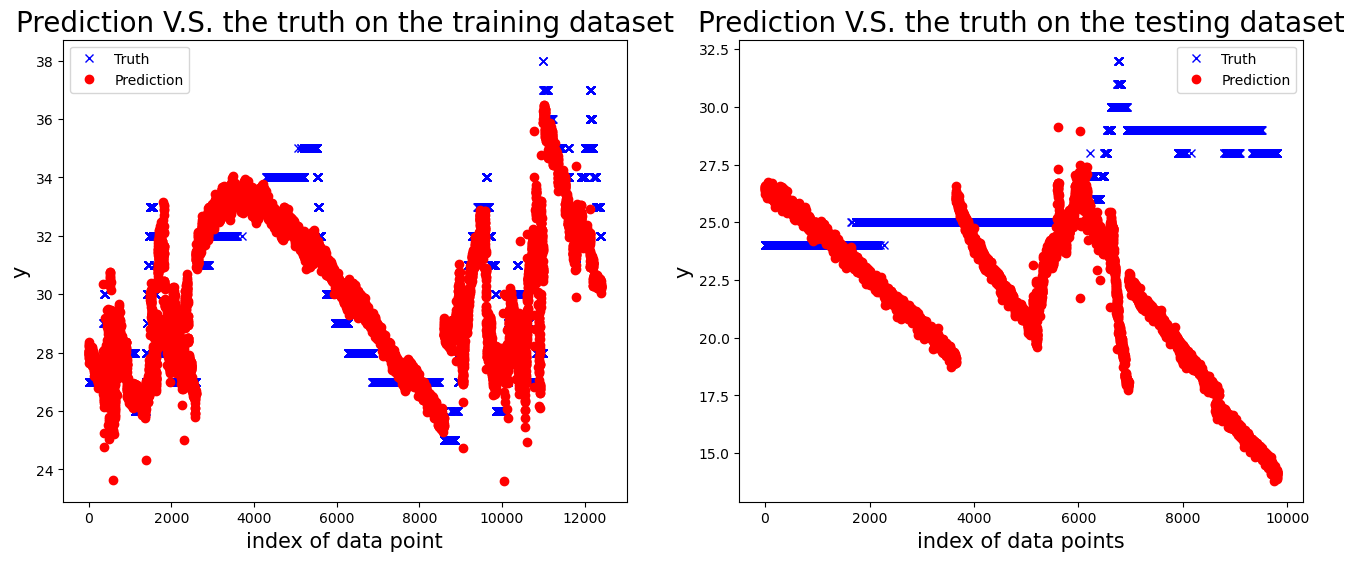

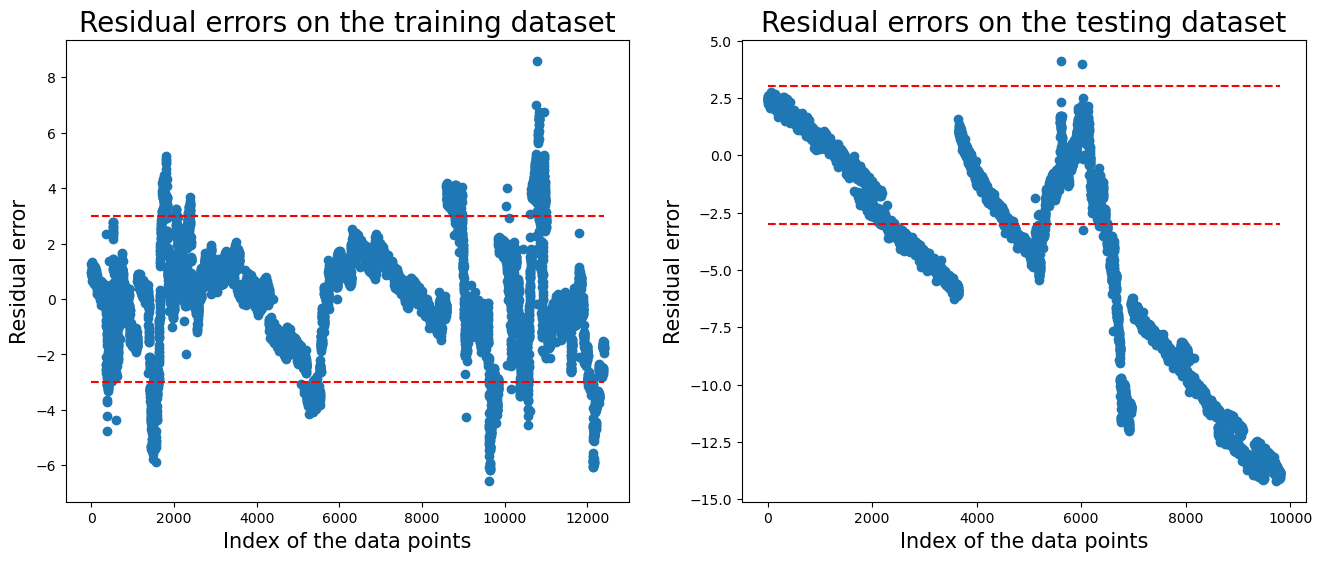

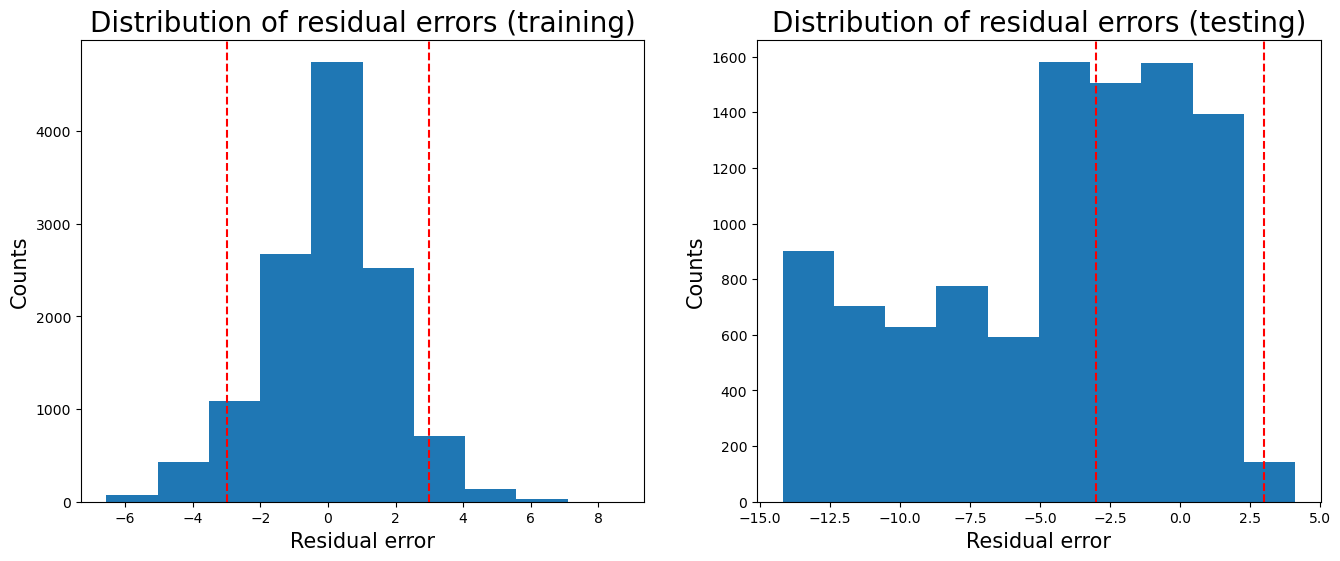


 New cv run:

Training performance, max error is: 9.439721202888506
Training performance, mean root square error is: 1.847563458952164
Training performance, residual error > 3: 7.928303855090331%


Prediction performance, max error is: 14.922848329548913
Prediction performance, mean root square error is: 5.5174839674633285
Prediction performance, percentage of residual error > 3：86.45739910313901%


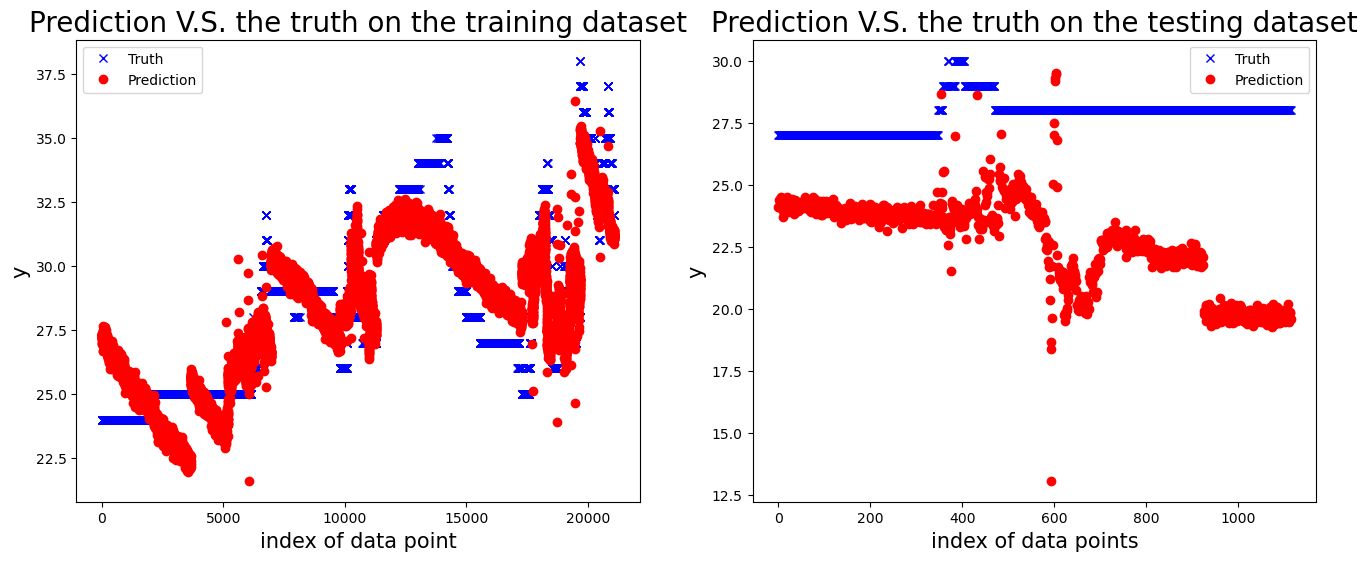

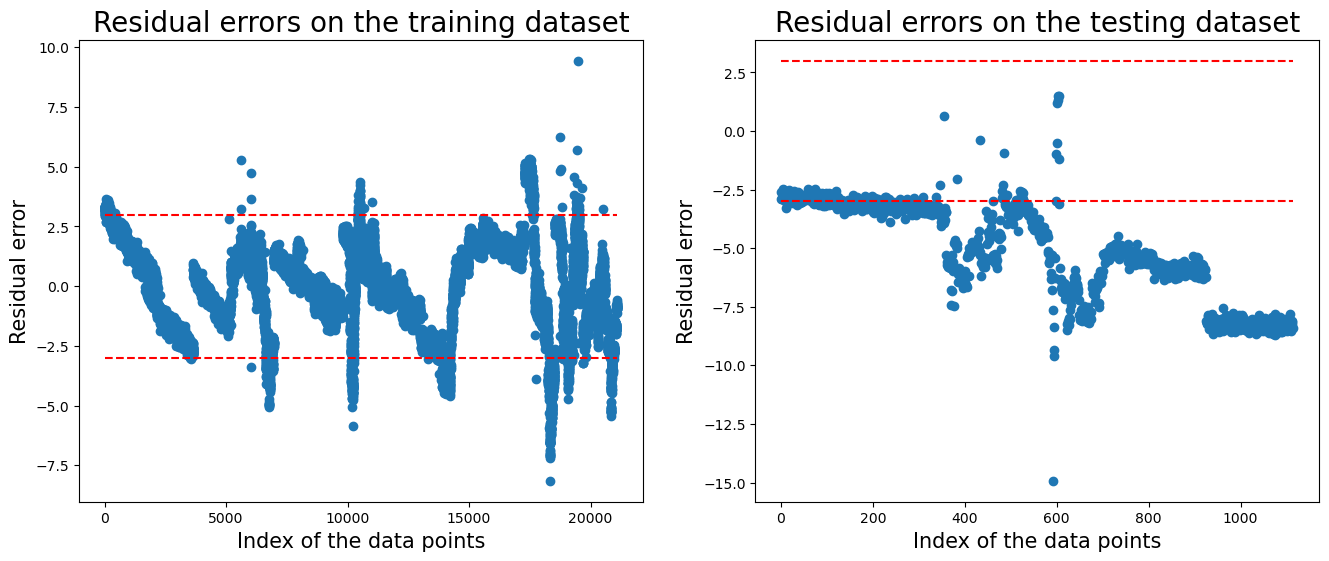

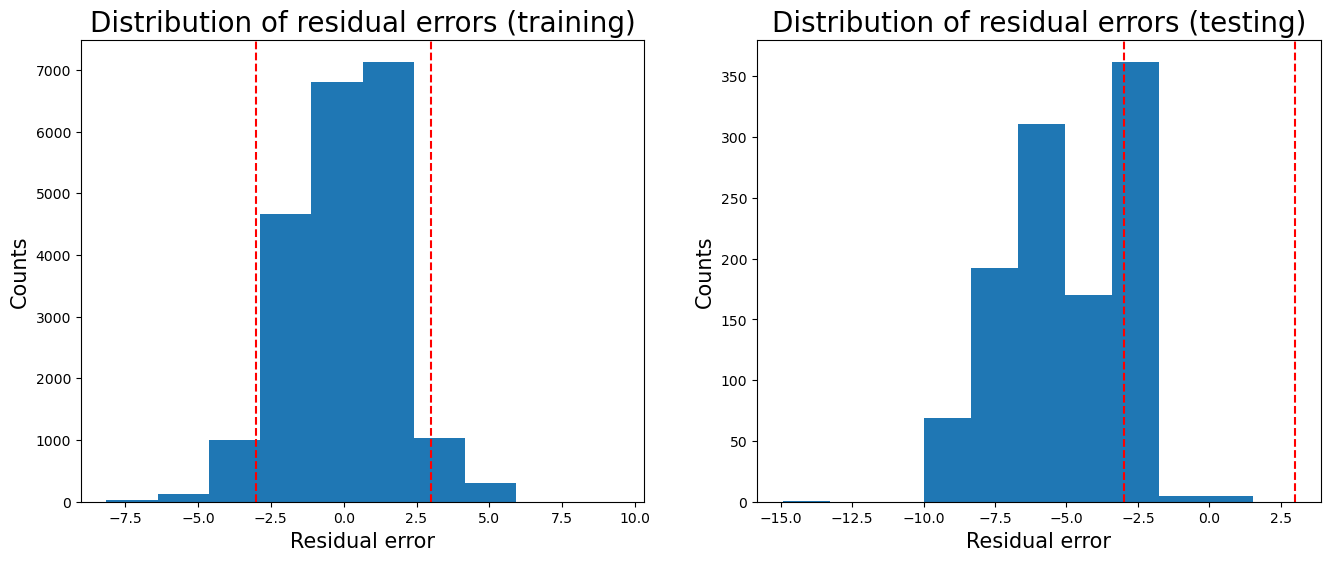


 New cv run:

Training performance, max error is: 7.189896939999173
Training performance, mean root square error is: 1.3944809066505286
Training performance, residual error > 3: 5.224877541932611%


Prediction performance, max error is: 8.119139683624912
Prediction performance, mean root square error is: 4.2275306974443225
Prediction performance, percentage of residual error > 3：46.28865979381443%


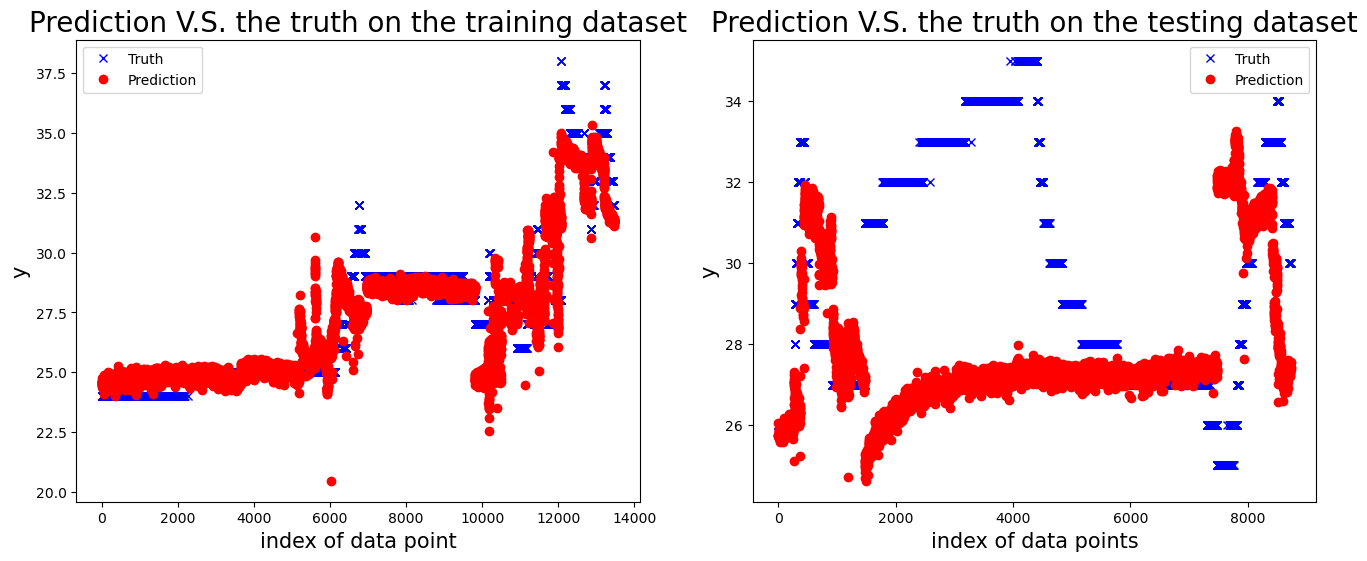

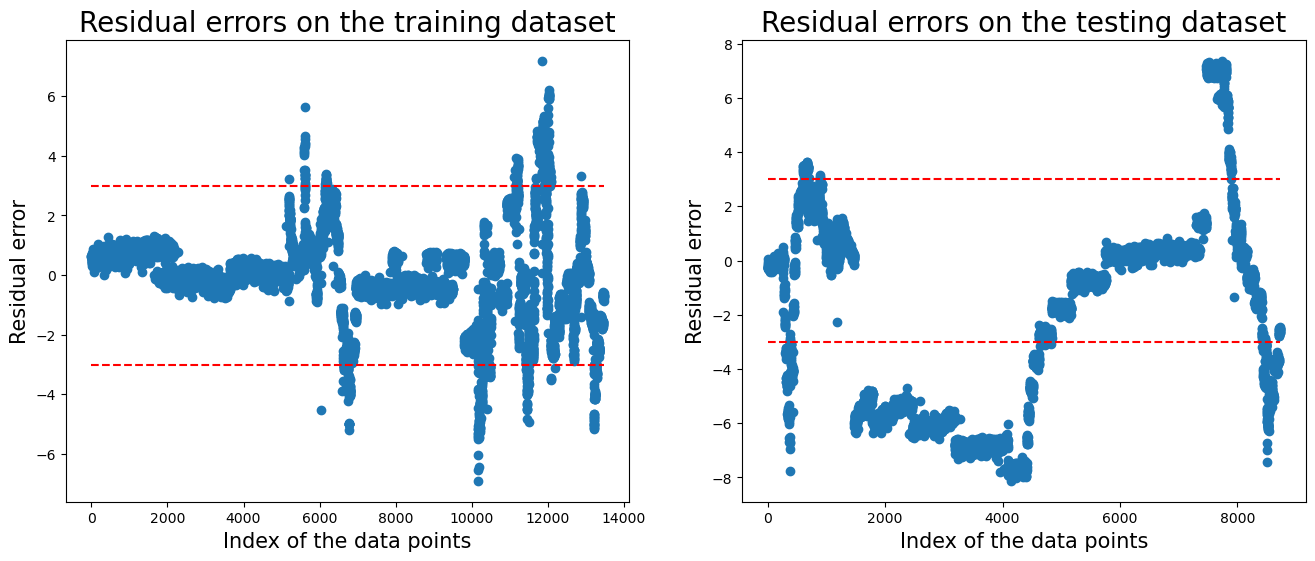

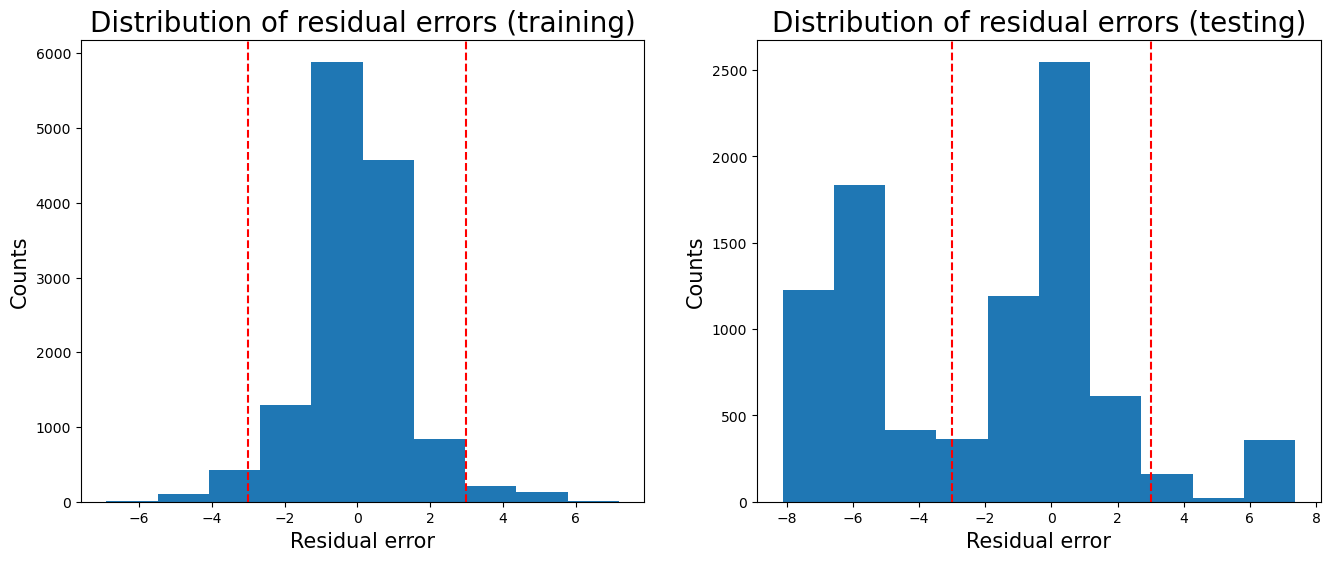


 New cv run:

Training performance, max error is: 10.198785616659578
Training performance, mean root square error is: 1.8213299485747063
Training performance, residual error > 3: 7.872728122225856%


Prediction performance, max error is: 11.165309278204717
Prediction performance, mean root square error is: 5.164454170179014
Prediction performance, percentage of residual error > 3：49.43820224719101%


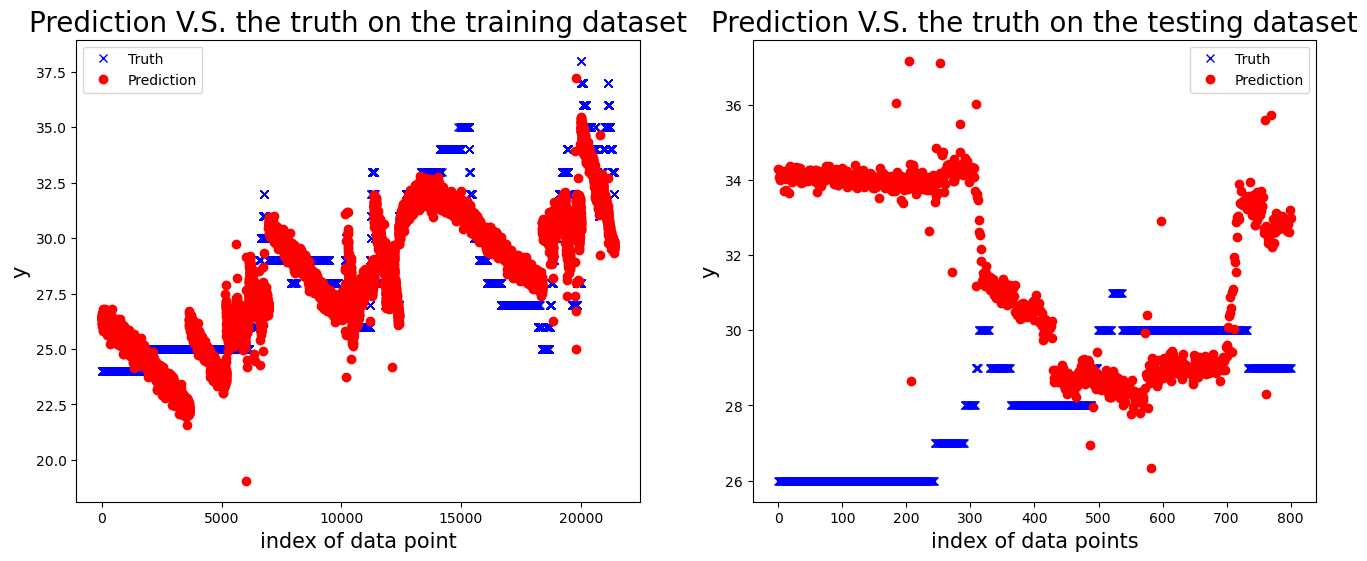

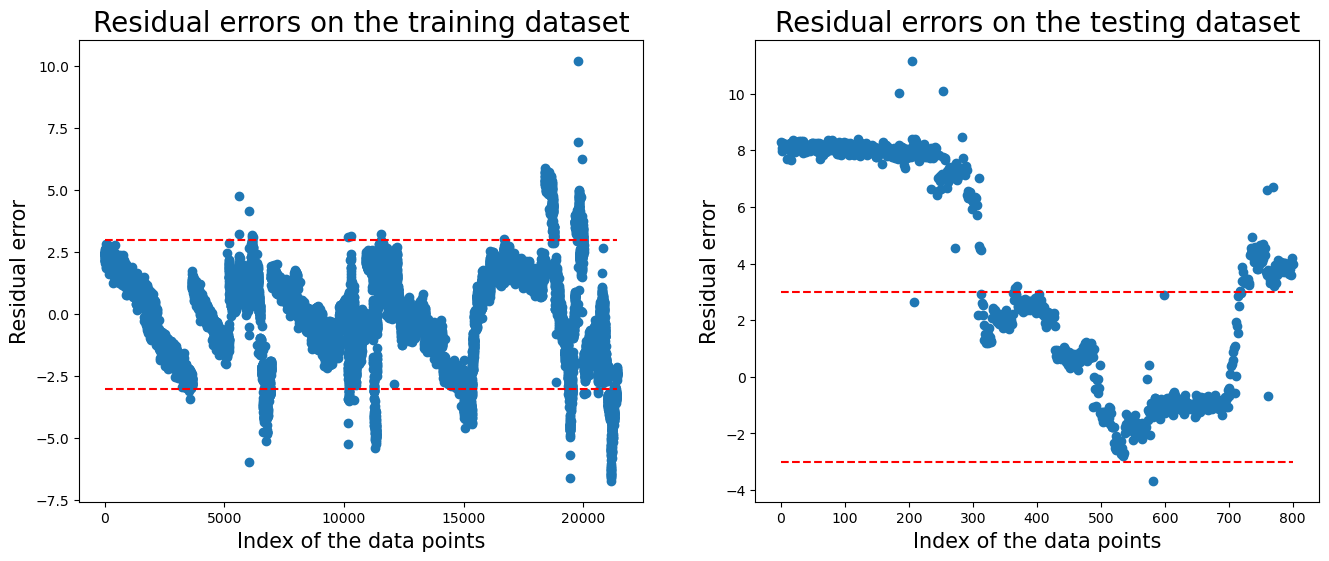

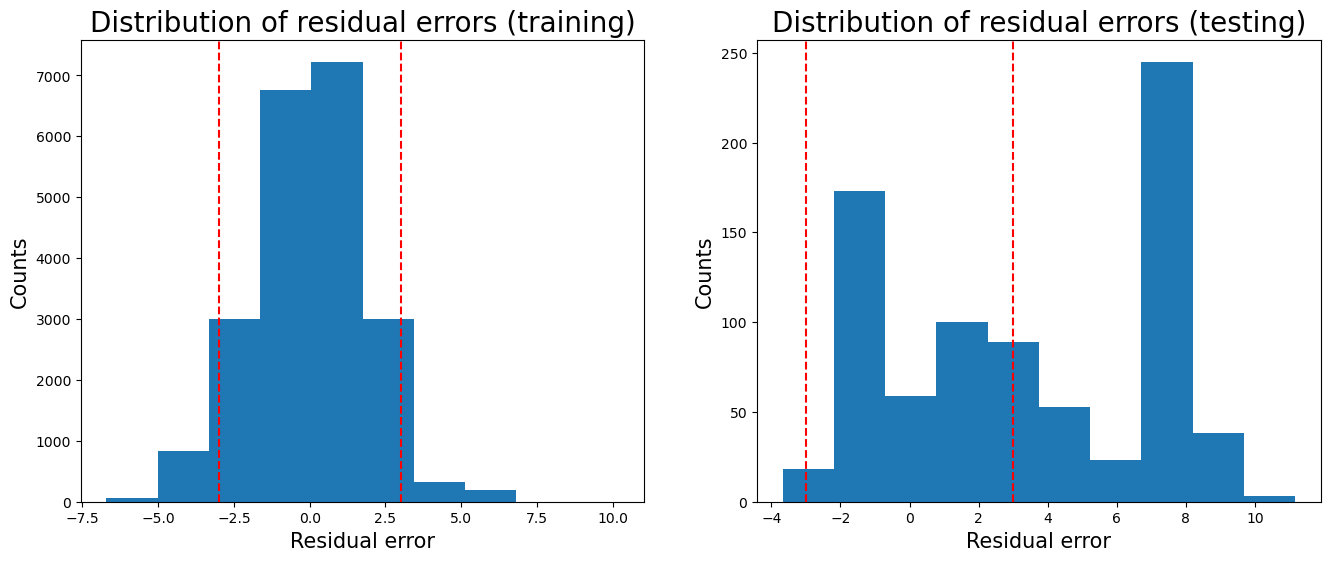


 New cv run:

Training performance, max error is: 8.421150296842434
Training performance, mean root square error is: 1.7884456445851125
Training performance, residual error > 3: 7.372641048205731%


Prediction performance, max error is: 9.649758439654942
Prediction performance, mean root square error is: 5.181160963049
Prediction performance, percentage of residual error > 3：75.94285714285715%


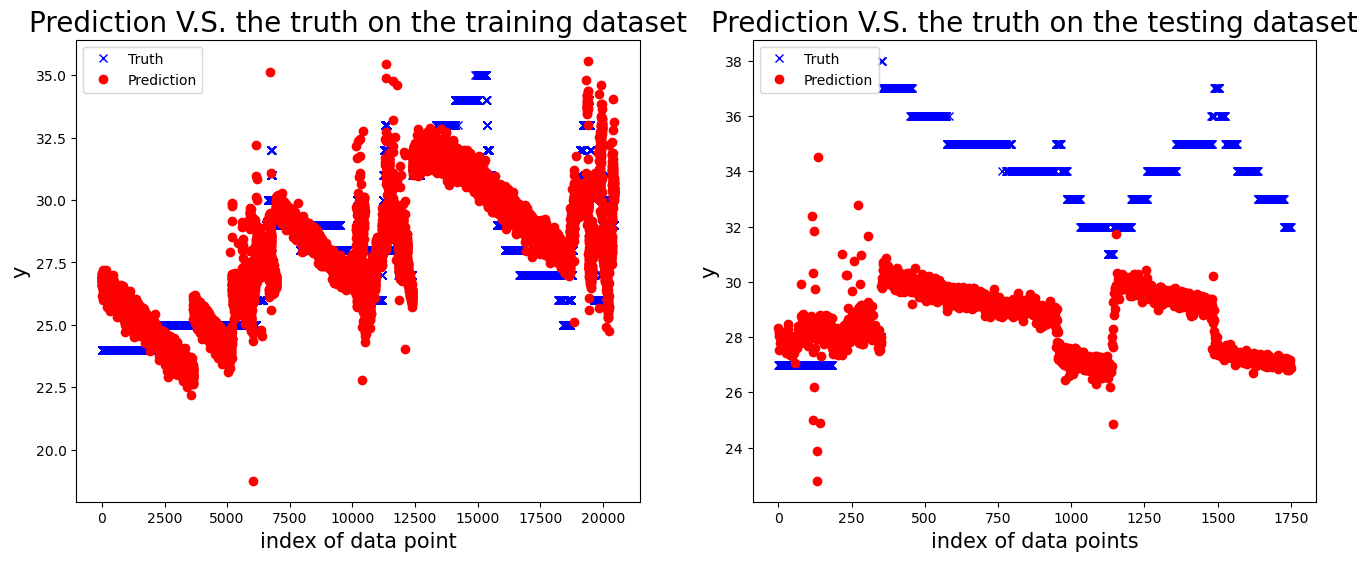

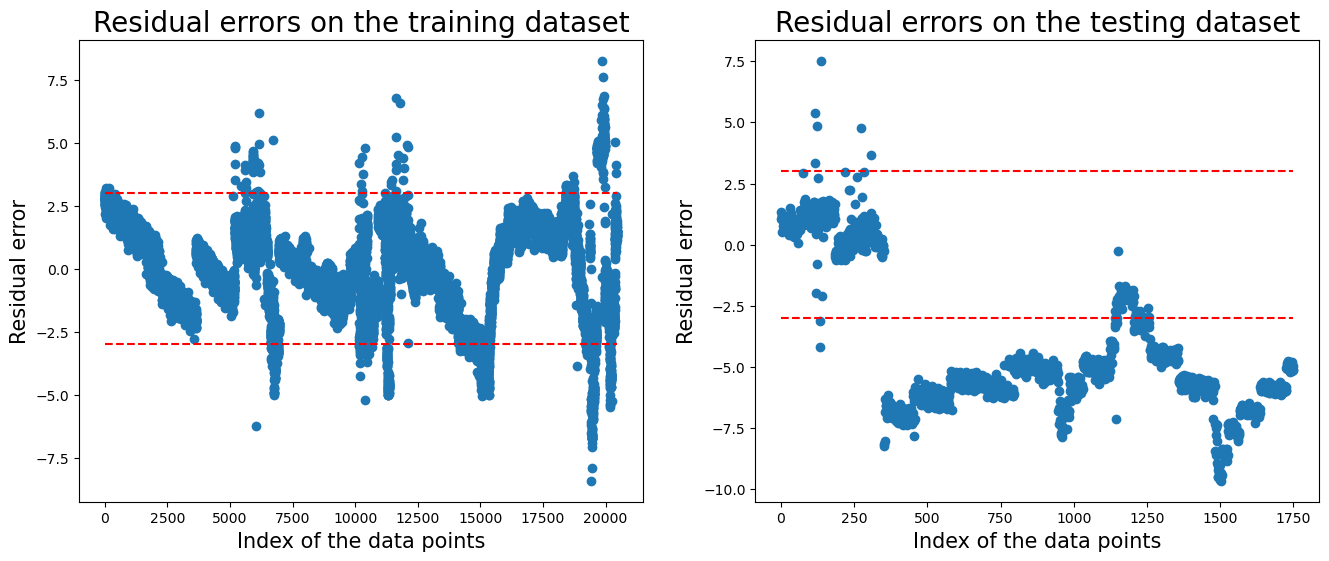

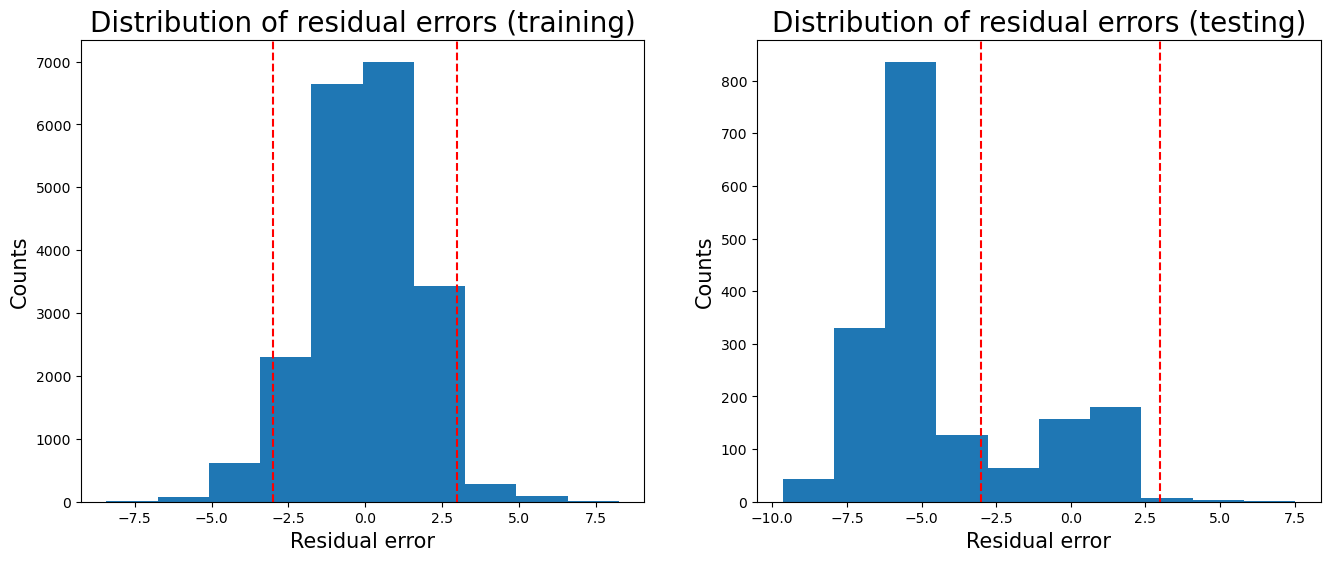

   Max error      RMSE  Exceed boundary rate
0  14.192110  6.499171              0.547818
1  14.922848  5.517484              0.864574
2   8.119140  4.227531              0.462887
3  11.165309  5.164454              0.494382
4   9.649758  5.181161              0.759429


Mean performance metric and standard error:
Max error: 11.6098 +- 2.9098
RMSE: 5.3180 +- 0.8165
Exceed boundary rate: 0.6258 +- 0.1766




In [5]:
from utility import run_cv_one_motor

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, 
            feature_list=feature_list_all, n_fold=5, mdl_type='reg')

### Define a function to run the cross validation for all the motors.

In [6]:
from utility import run_cv_one_motor


def run_all_motors(df_data, mdl, feature_list, n_fold=5, threshold=3, window_size=1, single_run_result=True, mdl_type='reg'):
    all_results = []
    # Loop over all the six motors.
    for i in range(1, 7):
        print(f'Model for predicting temperature of motor {i}:')
        # Run cross validation.
        df_perf = run_cv_one_motor(motor_idx=i, df_data=df_data, mdl=mdl, feature_list=feature_list,
                n_fold=n_fold, threshold=threshold, window_size=window_size, single_run_result=single_run_result, mdl_type=mdl_type)
        all_results.append(df_perf)

    return all_results

## Train a linear regression model using a 5-fold cross validation

Then, we run a 5 fold cross validation.

### Only removing outliers

In [7]:
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
all_results = run_all_motors(df_data=df_data, mdl=mdl_linear_regreession, feature_list=feature_list_all, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error       RMSE  Exceed boundary rate
0  30.574690  14.960329              0.726754
1  38.618150   9.031082              0.783857
2  26.025481  10.762112              0.965979
3  25.697067  12.619383              0.998752
4  20.786006   3.604336              0.439429


Mean performance metric and standard error:
Max error: 28.3403 +- 6.7089
RMSE: 10.1954 +- 4.2924
Exceed boundary rate: 0.7830 +- 0.2243


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   9.971889  4.580278              0.434951
1  28.776806  9.150537              1.000000
2  14.604056  7.135632              0.826002
3   8.911941  5.011460              0.891386
4   7.783340  2.864531              0.276571


Mean performance metric and standard error:
Max error: 14.0096 +- 8.6527
RMSE: 5.7485 +- 2.4353
Exceed boundary rate: 0.6858 +- 0.3127


Model for predicting temperature of motor 3:
Mo

### Smoothing

In [8]:
all_results = run_all_motors(df_data=df_data_smoothing, mdl=mdl_linear_regreession, feature_list=feature_list_all, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error       RMSE  Exceed boundary rate
0  31.374247  14.964456              0.727263
1  38.494568   9.008100              0.785650
2  25.541015  10.803662              0.964948
3  26.153128  12.676969              1.000000
4  19.634154   3.647346              0.449143


Mean performance metric and standard error:
Max error: 28.2394 +- 7.0831
RMSE: 10.2201 +- 4.2882
Exceed boundary rate: 0.7854 +- 0.2206


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0  10.014490  4.549221              0.435359
1  15.234175  9.112374              1.000000
2  14.095669  7.231014              0.820619
3   9.036737  5.011076              0.890137
4   7.752044  2.859704              0.274286


Mean performance metric and standard error:
Max error: 11.2266 +- 3.2646
RMSE: 5.7527 +- 2.4413
Exceed boundary rate: 0.6841 +- 0.3125


Model for predicting temperature of motor 3:
Mo

## Use a sliding window to predict the next point

In this section, we show a demonstration of how to use a sliding window to predict the next point. We first define a window. Then, the previous points in the window will be used to predict the next point. When the window size shrink to 1, it is equial to the previous model.

### Only removing outliers

In [9]:
all_results = run_all_motors(df_data=df_data, mdl=mdl_linear_regreession, feature_list=feature_list_all, window_size=5, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0   1.078512  0.152428                   0.0
1   1.009756  0.143267                   0.0
2   1.100484  0.184995                   0.0
3   1.091637  0.165735                   0.0
4   1.046584  0.197751                   0.0


Mean performance metric and standard error:
Max error: 1.0654 +- 0.0372
RMSE: 0.1688 +- 0.0225
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   1.110195  0.094591               0.00000
1  15.578681  0.564089               0.00272
2   2.247747  0.134908               0.00000
3   1.067991  0.126876               0.00000
4   1.058515  0.128926               0.00000


Mean performance metric and standard error:
Max error: 4.2126 +- 6.3740
RMSE: 0.2099 +- 0.1986
Exceed boundary rate: 0.0005 +- 0.0012


Model for predicting temperature of motor 3:
Model for m

### Smoothing

In [10]:
all_results = run_all_motors(df_data=df_data_smoothing, mdl=mdl_linear_regreession, feature_list=feature_list_all, window_size=5, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0   1.079782  0.152698                   0.0
1   1.150462  0.152014                   0.0
2   1.107900  0.190174                   0.0
3   1.093521  0.167372                   0.0
4   1.046870  0.197715                   0.0


Mean performance metric and standard error:
Max error: 1.0957 +- 0.0380
RMSE: 0.1720 +- 0.0211
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   1.048594  0.086204                   0.0
1   1.197195  0.134572                   0.0
2   1.082607  0.130724                   0.0
3   1.042265  0.116724                   0.0
4   1.026752  0.123255                   0.0


Mean performance metric and standard error:
Max error: 1.0795 +- 0.0689
RMSE: 0.1183 +- 0.0192
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting temperature of motor 3:
Model for m